In [425]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [426]:
df = pd.read_csv("weatherAUS_clean.csv")
print(df.shape)
df.head()

(123710, 29)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Day,winter,spring,summer,autumn,winterRain,springRain,summerRain,autumnRain,RainTomorrow
0,13.4,22.9,0.6,4.8,8.6,44.0,20.0,24.0,71.0,22.0,...,1,True,False,False,False,False,False,False,False,0
1,7.4,25.1,0.0,4.8,8.6,44.0,4.0,22.0,44.0,25.0,...,2,True,False,False,False,False,False,False,False,0
2,12.9,25.7,0.0,4.8,8.6,46.0,19.0,26.0,38.0,30.0,...,3,True,False,False,False,False,False,False,False,0
3,9.2,28.0,0.0,4.8,8.6,24.0,11.0,9.0,45.0,16.0,...,4,True,False,False,False,False,False,False,False,0
4,17.5,32.3,1.0,4.8,8.6,41.0,7.0,20.0,82.0,33.0,...,5,True,False,False,False,False,False,False,False,0


In [427]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Year', 'Month', 'Day', 'winter',
       'spring', 'summer', 'autumn', 'winterRain', 'springRain', 'summerRain',
       'autumnRain', 'RainTomorrow'],
      dtype='object')

In [428]:
target = "RainTomorrow"
features = ['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday',
 'Year',
 'Month',
 'Day',
 'winter',
 'spring',
 'summer',
 'autumn',
 'winterRain',
 'springRain',
 'summerRain',
 'autumnRain',
 'latitude',
 'longitude']


In [429]:
df[features] = df[features].apply(lambda x: (x-x.mean())/x.std())

In [430]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend import set_session

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers import PReLU


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import time
%matplotlib inline

import gc

In [431]:
# Funkcja pomocnicza,która pozwoli nam również zaawansowane funkcje aktywacji wybierać po imieniu
def actModel(model, activation):
    if activation == "prelu":
        model.add(
            keras.layers.advanced_activations.PReLU(
                weights=None, alpha_initializer="zero"
            )
        )
    else:
        model.add(Activation(activation))
    return


# Wydzielona funkcja, która odpowiada wyłącznie za budowę sieci.
def create_network(
    n=3,
    nu1=10,
    nu2=5,
    nu3=5,
    nu4=5,
    nu5=5,
    activation="relu",
    dropout=Dropout,
    dropout_rate=0,
    regu=0,
    kernel_initializer="lecun_normal",
    optimizer="SGD",
    num_classes=1,
    inputShape=10,
    dropout_all_layers=False,
    debug=False,
    *args,
    **kwargs
):
    nu = [nu1, nu2, nu3, nu4, nu5]
    # Jeżeli włączony jest tryb debug wyświetlimy parametry funkcji
    if debug:
        print(locals())

    # Inicjacja podstawowego modelu keras w trybie sekwencyjnym
    # W ten sposób najłatwiej zbutować w pełni połączone sieci feed forward.
    model = Sequential()

    # Definicja inputów do sieci oraz pierwszej warstwy
    # nu[0] odpowiada za liczbę neuronów w pierwszej warstwie
    # dodatkowo ustalamy jak inicjalizować parametry raz czy stosować refularyzację.
    model.add(
        Dense(
            nu[0],
            input_shape=(inputShape,),
            kernel_initializer=kernel_initializer,
            kernel_regularizer=regularizers.l2(regu),
        )
    )

    # Dodanie funkcji aktywacji do pierwszej warstwy.
    actModel(model, activation)

    # Opcjonalne włączenie mechanizmu dropout
    if dropout_rate > 0.01:
        model.add(dropout(dropout_rate))

    # Kolejne warstwy budowane są w ten sam sposób, co pozwala budować je w pętli
    # Pierwsza warstwa jako jedyna musiała mieć zdefiniowany input
    # W pozostałych warstwach model automatycznie keras połączy warstwy,
    # Input do kolejnej warstwy będzie outputem z wcześniejszych warstw.
    for i in range(1, n):
        # Inicjalizacja warstwy przez potanie liczby neuronów oraz sposobu inicjacji
        model.add(Dense(nu[i], kernel_initializer=kernel_initializer))
        # Definicja funkcji aktywacji
        actModel(model, activation)

        # Opcjonalne dodanie dropout
        if dropout_rate > 0.01 and dropout_all_layers:
            model.add(dropout(dropout_rate))

    # Aby "zakończyć" sieć niezbędne jest przygotowanie odpowiedniej liczby neuronów
    # Wystarczy jeden neuron dla regresji
    # Dla klasyfikacji binarnej oraz wieloklasowej potrzeba tyle neuronów co klas.
    # Dla binarne będą to dwa neurony.
    # W przypadku klasyfikacji wieloklasowej target musi być również podany w postaci one- hot encoding.
    model.add(Dense(num_classes))

    # Dla klasyfikacji binarnej lub wieloklasowej jako funkcję aktywacji stosujemy softmax
    # Będzie on odpowiadał transformacji logistycznej.
    # W problemie regresji możemy po prostu wykorzystać funkcję liniową.
    # Na chwilę obecną budujemy wrapper dla klasyfikacji binarnej
    # Poniżej pozostawiamy softmax, z funkcją straty categorical_crossentropy oraz accuracy jak bazową metryką.
    model.add(Activation("softmax"))
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    return model


In [432]:
from sklearn.metrics import roc_auc_score
# Funkcja net będzie naszym wrapperem do budowania siecie, trenowania, oraz zbierania wyników/statystyk.
def net(train, test, features, target, epochs = 30, batchSize=100, debug=False, *args, **kwargs):
    
    # Przygotowanie zmiennych
    y_train = pd.get_dummies(train[target]).values
    y_test = pd.get_dummies(test[target]).values
    x_train = train[features].values
    x_test = test[features].values
    
    num_classes = y_train.shape[1]
    
    # Wyświetlenie informacji opisowych jeżeli jesteśmy w trybie debugowym
    if debug:
        print('Loading data...')
        print(len(x_train), 'train sequences')
        print(len(x_test), 'test sequences')
        print(num_classes, 'classes')
        print('x_train shape:', x_train.shape)
        print('x_test shape:', x_test.shape)
        print('\nBuilding network 1...')
    
    # Stworzenie modelu z użyciem funkcji create_network.
    model = create_network(num_classes=num_classes, inputShape=x_train.shape[1], debug=debug, *args, **kwargs)
    
    # Przygotowanie zmiennych do przechowywania statystyk dotyczących szkolenia
    history_model = dict()
    loss = []
    valLoss = []
    acc = []
    valAcc = []
    auc = []
    valAuc = []
    
    
    bestTrainProba = []
    bestTestProba = []
    bestAuc = 0
    # Iteracyjne uruchomienie szkolenia.
    # UWAGA! W "profesjonalnym" wykorzystaniu Kerasa stosuje się tzw. callbacki, 
    # callbacki to funkcje do uruchamiania pomiędzy iteracjami.
    # W naszej dydaktycznej implementacji sami będziemy iterować szkolenie w pętli po jednej iteracji
    for z in range(epochs):
        # Wykonaj jedną ideacje szkolenia
        histModel = model.fit(x_train,
                                    y_train,
                                    batch_size=batchSize,
                                    epochs=1,
                                    verbose=debug,
                                    validation_split=0.0,
                                   validation_data=(x_test, y_test))
        # Zrób prognoze na zbiorze treningowym
        probaTrain = model.predict(x_train,
                                       batch_size=y_train.shape[0],
                                       verbose=debug)
        # Zrób prognozę na zbiorze testowym
        probaTest = model.predict(x_test,
                                       batch_size=y_test.shape[0],
                                       verbose=debug)
        # Obliczenie statystyk AUC
        # We wcześniejszych wersjach Keras nie miał wbudowanego liczenia auc pomiędzy iteracjami
        aucTrain = roc_auc_score(train[target], probaTrain[:,1])
        aucTest = roc_auc_score(test[target], probaTest[:,1])
        if debug:
            print(aucTrain, aucTest)
            
        # Ręczna implementacja zapisywania prognoz z najlepszej iteracji
        if aucTest>bestAuc:
            bestAuc = aucTest
            bestTrainProba = probaTrain[:, 1].tolist()
            bestTestProba = probaTest[:, 1].tolist()
        
        # Zapisanie wyników w tej iteracji
        print(histModel.history)
        loss.append(histModel.history['loss'][0])
        valLoss.append(histModel.history['val_loss'][0])
        acc.append(histModel.history['accuracy'][0])
        valAcc.append(histModel.history['val_accuracy'][0])
        auc.append(aucTrain)
        valAuc.append(aucTest)
        
    # Zapisanie wyników ze wszystkich iteracji do słownika
    history_model['loss'] = loss
    history_model['valLoss'] = valLoss
    history_model['acc'] = acc
    history_model['valAcc'] = valAcc
    history_model['auc'] = auc
    history_model['valAuc'] = valAuc
    return max(valAuc), bestTrainProba, bestTestProba, history_model


In [433]:
test_size=0.3
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2020, stratify=df[target].values)
score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=2, nu1=400, nu2=100,
                                                    epochs = 50, batchSize=500, debug=True)
print(score)

Loading data...
86597 train sequences
37113 test sequences
2 classes
x_train shape: (86597, 28)
x_test shape: (37113, 28)

Building network 1...
{'n': 2, 'nu1': 400, 'nu2': 100, 'nu3': 5, 'nu4': 5, 'nu5': 5, 'activation': 'relu', 'dropout': <class 'keras.layers.regularization.dropout.Dropout'>, 'dropout_rate': 0, 'regu': 0, 'kernel_initializer': 'lecun_normal', 'optimizer': 'SGD', 'num_classes': 2, 'inputShape': 28, 'dropout_all_layers': False, 'debug': True, 'args': (), 'kwargs': {}, 'nu': [400, 100, 5, 5, 5]}
1/1 [==============================] - 0s 90ms/step
0.850283031162293 0.8465648296247721
{'loss': [0.41222473978996277], 'accuracy': [0.8201670050621033], 'val_loss': [0.3789369761943817], 'val_accuracy': [0.8350173830986023]}
1/1 [==============================] - 0s 65ms/step
0.861628193767039 0.8577843844357035
{'loss': [0.36694636940956116], 'accuracy': [0.8411492109298706], 'val_loss': [0.3660274147987366], 'val_accuracy': [0.8407027125358582]}
1/1 [========================

0.8820034973600299


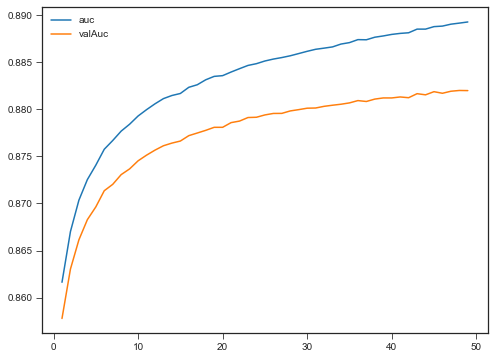

In [434]:
history = pd.DataFrame(history)
print(history.valAuc.max())
history.loc[1:, ["auc", "valAuc"]].plot(figsize=(8,6))
plt.show()

In [435]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy prosty wrapper
def CVTestNN(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapamiętujemy wyniki zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Razem z informacją o tym, jaki był ich indeks w oryginalnym zbiorze danych
    indices = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, history = net(df.iloc[train], df.iloc[test], features, target,
                                                            debug=False, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        
        hists.append(history)
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, hists

In [443]:
import random

opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]

results = []
paramList = []
for x in range(20):
    params = (
        random.randint(1, 5),
        random.randint(10, 500),
        random.randint(10, 500),
        random.randint(10, 500),
        random.randint(10, 500),
        random.randint(10, 500),
        random.randint(50, 500),
        random.randint(0, 5),
        random.randint(0, 5),
        random.uniform(0, 0.8),
        random.randint(0, 1),
    )
    trainResults, testResults, predictions, indices, hists = CVTestNN(
        n=params[0],
        nu1=params[1],
        nu2=params[2],
        nu3=params[3],
        nu4=params[4],
        nu5=params[5],
        batchSize=params[6],
        optimizer=opti[params[7]],
        activation=activations[params[8]],
        dropout_rate=params[9],
        dropout_all_layers=params[10] == 1,
        epochs=20,
        debug=False,
    )
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)


{'loss': [0.376733660697937], 'accuracy': [0.8339463472366333], 'val_loss': [0.3500364124774933], 'val_accuracy': [0.849769651889801]}
{'loss': [0.3576141595840454], 'accuracy': [0.8434241414070129], 'val_loss': [0.3432619869709015], 'val_accuracy': [0.8529625535011292]}
{'loss': [0.34991371631622314], 'accuracy': [0.8471323847770691], 'val_loss': [0.34095636010169983], 'val_accuracy': [0.8542155027389526]}
{'loss': [0.3462338447570801], 'accuracy': [0.8490319848060608], 'val_loss': [0.3391808569431305], 'val_accuracy': [0.8544984459877014]}
{'loss': [0.34288594126701355], 'accuracy': [0.8510730862617493], 'val_loss': [0.33992746472358704], 'val_accuracy': [0.8534879684448242]}
{'loss': [0.3410038948059082], 'accuracy': [0.8517197370529175], 'val_loss': [0.33727994561195374], 'val_accuracy': [0.8545792698860168]}
{'loss': [0.33977439999580383], 'accuracy': [0.8520935773849487], 'val_loss': [0.3398533761501312], 'val_accuracy': [0.8560342788696289]}
{'loss': [0.3377456068992615], 'accur

AttributeError: module 'keras.layers' has no attribute 'advanced_activations'

0.8793782895926798


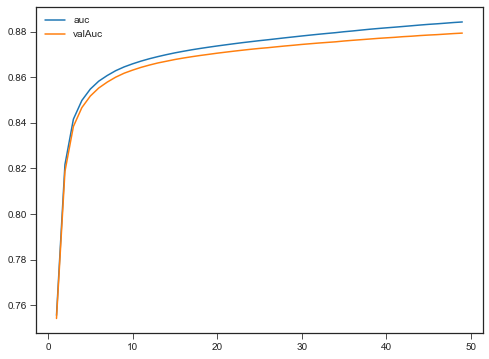

In [ ]:
history = pd.DataFrame(history)
print(history.valAuc.max())
history.loc[1:, ["auc", "valAuc"]].plot(figsize=(8,6))
plt.show()